Import requried libraries

In [ ]:
import cv2
import math
import csv
import numpy as np
import torch
import torch.nn as nn
from torch import nn, optim
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Resize
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

import os
from torch.utils.data import Dataset
from natsort import natsorted
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from datetime import datetime
from os.path import exists
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


Import train and test loader to perform task

In [ ]:
def get_train_test_loader(data_set, train_batch_size=64, test_batch_size=128):
  train_size = int(0.8 * len(data_set))
  test_size = len(data_set) - train_size
  train_set, test_set = torch.utils.data.random_split(data_set, [train_size, test_size])
  train_loader = torch.utils.data.DataLoader(
      train_set,
      batch_size=train_batch_size,
      shuffle=True,
      num_workers=2
  )
  test_loader = torch.utils.data.DataLoader(
      test_set,
      batch_size=test_batch_size,
      shuffle=True,
      num_workers=2
  )
  print(f"size of dataset: {len(data_set)} train_set: {train_size} test_set: {test_size}")
  return train_loader,test_loader

In [ ]:
main_dir = "/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Training/"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])
data_set = ImageFolder(root=main_dir, transform=transform)

train_loader, test_loader = get_train_test_loader(data_set)
classes = [fname for fname in os.listdir(main_dir)]

size of dataset: 2870 train_set: 2296 test_set: 574


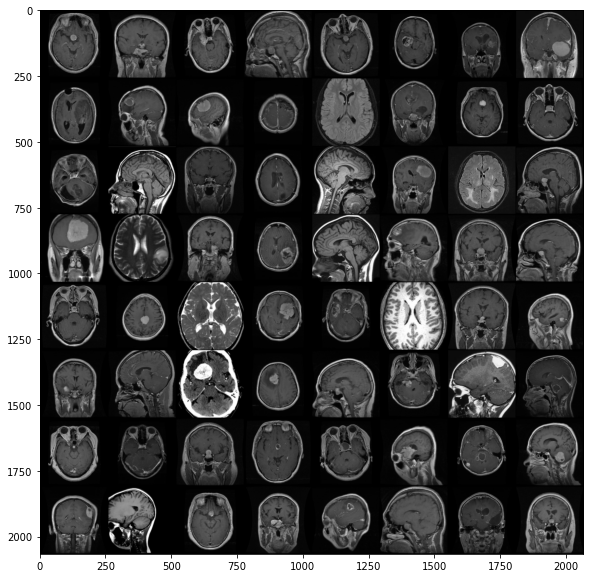

['no_tumor', 'no_tumor', 'glioma_tumor', 'no_tumor', 'no_tumor', 'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'pituitary_tumor', 'glioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor', 'glioma_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'glioma_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'no_tumor', 'glioma_tumor', 'glioma_tumor', 'no_tumor', 'glioma_tumor', 'glioma_tumor', 'no_tumor', 'glioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor', 'pituitary_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor', 'glioma_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor', 'pitu

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
images, labels = next(iter(train_loader))
# show images and labels
timshow(torchvision.utils.make_grid(images))
print([classes[label] for label in labels])

Stats


In [ ]:
def stats(loader, net, loss_fn):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    net.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
    net.train()
    return running_loss/n, correct/total 

Plot loss and accuracy of the models

In [ ]:
def plot_loss_and_accuracy(fileName, ax1, title=''):
    data = torch.load(f'/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/output/{fileName}')
    statsrec = data["stats"][:,:-2]
    ax1.plot(statsrec[0], 'r', label = 'training loss', )
    ax1.plot(statsrec[2], 'g', label = 'test loss' )
    ax1.legend(loc='lower right')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('Training and test loss, and test accuracy ' + title)
    ax2=ax1.twinx()
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'test accuracy')
    ax2.set_ylabel('accuracy')
    ax2.legend(loc='upper right')

train_model

In [ ]:
def train_model(model, train_loader, test_loader, fileName, nepochs = 1000, stopping_epoch_criteria = 10, logging_epoch_criteria = 5, lr=0.01):
  results_path = f'/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/output/{fileName}'
  start_epoch = 0
  model.train()
  statsrec = np.zeros((4,nepochs))
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  current_epoch = 1
  flag = False
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  if(exists(results_path)):
    data = torch.load(results_path)
    model.load_state_dict(torch.load(results_path)['state_dict'])
    start_epoch = len(data['stats'][0])
    current_epoch = start_epoch
    statsrec[:,:start_epoch] = data['stats']
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for epoch in range(start_epoch): 
      if(epoch % logging_epoch_criteria == 0):
        (ltrn, atrn, ltst, atst) = statsrec[:,epoch]
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
    if(epoch > stopping_epoch_criteria and statsrec[3,epoch]-statsrec[3,epoch-stopping_epoch_criteria] <= 0): 
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
        flag = True
  for epoch in range(start_epoch,nepochs):  # loop over the dataset multiple times
      if(flag):
        break
      correct = 0          # number of examples predicted correctly (for accuracy)
      total = 0            # number of examples
      running_loss = 0.0   # accumulated loss (for mean loss)
      n = 0                # number of minibatches
      start_time = datetime.now()
      
      for data in train_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward, backward, and update parameters
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
      
          # accumulate loss
          running_loss += loss.item()
          n += 1
          
          # accumulate data for accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)    # add in the number of labels in this minibatch
          correct += (predicted == labels).sum().item()  # add in the number of correct labels
      current_epoch += 1
      # collect together statistics for this epoch
      ltrn = running_loss/n
      atrn = correct/total 
      ltst, atst = stats(test_loader, model, loss_fn)
      statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
      end_time= datetime.now()
      if(epoch % logging_epoch_criteria == 0):
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%} time: {end_time-start_time}")
        torch.save({"state_dict": model.state_dict(), "stats": statsrec[:,:current_epoch]}, results_path)
      if(epoch > 0 and statsrec[3,epoch]-statsrec[3,epoch-stopping_epoch_criteria] <= 0): 
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%} time: {end_time-start_time}")
        break; # break if the test accuracy does not increase after 5 epochs 

  
  # save network parameters, losses and accuracy
  torch.save({"state_dict": model.state_dict(), "stats": statsrec[:,:current_epoch]}, results_path)

A model one 

In [ ]:
class BrainTumourModel(nn.Module):

    def __init__(self, num_classes):
        super(BrainTumourModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*32*32,256),    
            nn.ReLU(inplace=True),
            nn.Linear(256,num_classes)
        )
  
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
net = BrainTumourModel(num_classes = len(classes))
for param in net.parameters():
    print(param.shape)
outputs = net(images)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 262144])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


In [ ]:
fileName = 'cnn3layer.pt'
train_model(net, train_loader, test_loader, fileName, logging_epoch_criteria=5, lr=0.001)#, lr=0.001

epoch: 0 training loss:  1.362 training accuracy:  36.4%  test loss:  1.321 test accuracy:  46.2%
epoch: 5 training loss:  0.818 training accuracy:  65.0%  test loss:  0.789 test accuracy:  66.4%
epoch: 10 training loss:  0.603 training accuracy:  76.8%  test loss:  0.600 test accuracy:  76.7%
epoch: 15 training loss:  0.492 training accuracy:  80.0%  test loss:  0.517 test accuracy:  79.8%
epoch: 20 training loss:  0.338 training accuracy:  86.8%  test loss:  0.448 test accuracy:  82.4%
epoch: 25 training loss:  0.211 training accuracy:  92.5%  test loss:  0.469 test accuracy:  85.0%
epoch: 30 training loss:  0.141 training accuracy:  95.8%  test loss:  0.437 test accuracy:  86.1%
epoch: 35 training loss:  0.066 training accuracy:  98.3%  test loss:  0.468 test accuracy:  87.3%
epoch: 40 training loss:  0.040 training accuracy:  99.1%  test loss:  0.481 test accuracy:  87.8%
epoch: 42 training loss:  0.040 training accuracy:  99.1%  test loss:  0.481 test accuracy:  87.8%


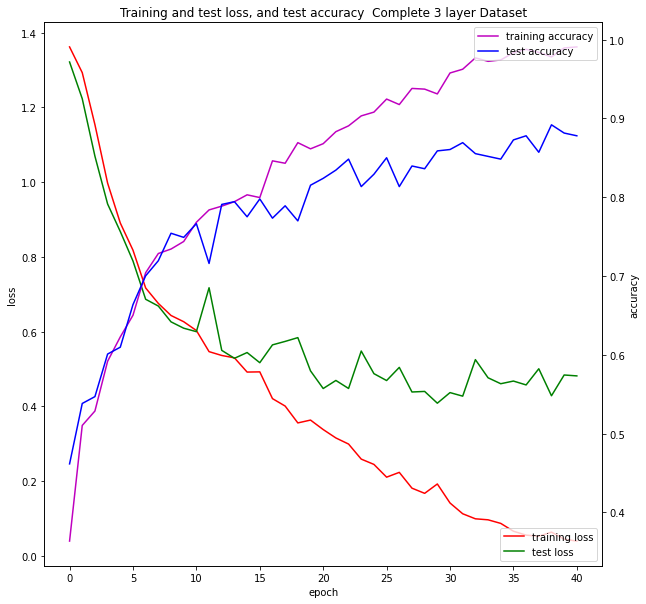

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
plot_loss_and_accuracy(fileName,axs, ' Complete 3 layer Dataset')
plt.show()

Training a model two with different parameters of the layers

In [ ]:
model2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(131072,256),    
    nn.ReLU(inplace=True),
    nn.Linear(256,len(classes))
)

for param in model2.parameters():
    print(param.shape)
op= model2(images)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 131072])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


In [ ]:
fileName = 'cnn3layerPoolingDropout.pt'
train_model(model2, train_loader, test_loader, fileName, logging_epoch_criteria=5, lr=0.001)#, lr=0.0001

epoch: 0 training loss:  1.028 training accuracy:  55.2%  test loss:  1.330 test accuracy:  53.0%
epoch: 5 training loss:  0.332 training accuracy:  87.4%  test loss:  0.505 test accuracy:  81.2%
epoch: 10 training loss:  0.115 training accuracy:  96.7%  test loss:  0.407 test accuracy:  88.2%
epoch: 15 training loss:  0.070 training accuracy:  98.0%  test loss:  0.413 test accuracy:  85.2%
epoch: 20 training loss:  0.029 training accuracy:  99.4%  test loss:  0.356 test accuracy:  89.9%
epoch: 25 training loss:  0.015 training accuracy:  99.9%  test loss:  0.376 test accuracy:  90.1%
epoch: 30 training loss:  0.007 training accuracy:  100.0%  test loss:  0.375 test accuracy:  88.9%
epoch: 31 training loss:  0.007 training accuracy:  100.0%  test loss:  0.375 test accuracy:  88.9%


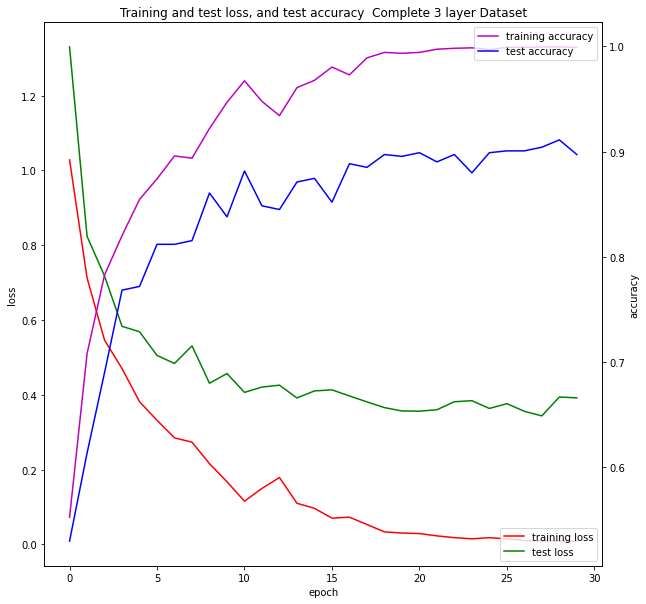

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
plot_loss_and_accuracy(fileName,axs, ' Complete 3 layer Dataset')
plt.show()

# A model three along with layers and different parameters

In [ ]:

model3 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(262144,256),    
    nn.ReLU(inplace=True),
    nn.Linear(256,len(classes))
)

for param in model3.parameters():
    print(param.shape)
_=model3(images)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 262144])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


In [ ]:
fileName = 'cnn3layerHigherOpChannels.pt'
train_model(model3, train_loader, test_loader, fileName, logging_epoch_criteria=5, lr=0.001)#, lr=0.0001

epoch: 0 training loss:  0.929 training accuracy:  58.9%  test loss:  1.288 test accuracy:  52.6%
epoch: 5 training loss:  0.315 training accuracy:  88.4%  test loss:  0.499 test accuracy:  82.4%
epoch: 10 training loss:  0.149 training accuracy:  94.3%  test loss:  0.548 test accuracy:  78.6%
epoch: 15 training loss:  0.054 training accuracy:  98.6%  test loss:  0.637 test accuracy:  77.5%
epoch: 16 training loss:  0.054 training accuracy:  98.6%  test loss:  0.637 test accuracy:  77.5%


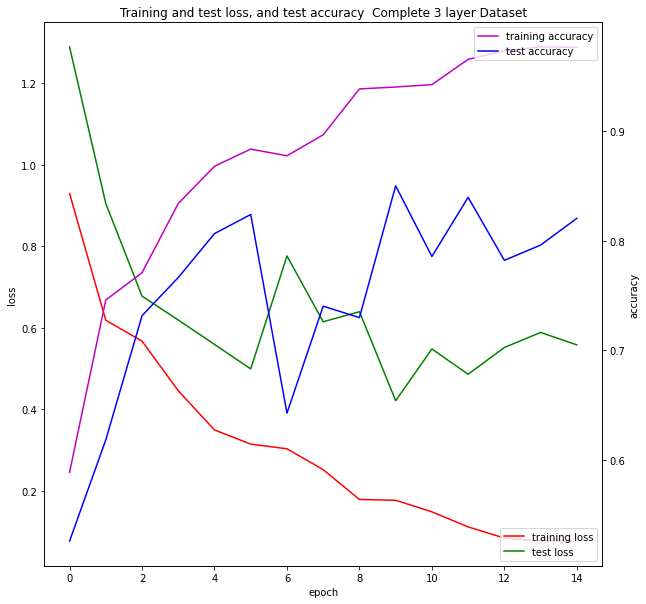

In [ ]:
fileName = 'cnn3layerHigherOpChannels.pt'
fig, axs = plt.subplots(figsize=(10,10))
plot_loss_and_accuracy(fileName,axs, ' Complete 3 layer Dataset')
plt.show()

A model four with five CNN layers 

In [ ]:
model4 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(),
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, len(classes)),
        )


for param in model4.parameters():
    print(param.shape)
_=model4(images)

torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([4096, 9216])
torch.Size([4096])
torch.Size([512, 4096])
torch.Size([512])
torch.Size([4, 512])
torch.Size([4])


In [ ]:
fileName = 'cnnFT5Layers.pt'
train_model(model4, train_loader, test_loader, fileName, logging_epoch_criteria=5, lr=0.001)#, lr=0.0001


epoch: 0 training loss:  1.383 training accuracy:  28.5%  test loss:  1.380 test accuracy:  28.2%
epoch: 5 training loss:  1.362 training accuracy:  29.0%  test loss:  1.360 test accuracy:  28.2%
epoch: 10 training loss:  1.355 training accuracy:  28.9%  test loss:  1.352 test accuracy:  28.2%
epoch: 11 training loss:  1.355 training accuracy:  28.9%  test loss:  1.352 test accuracy:  28.2%


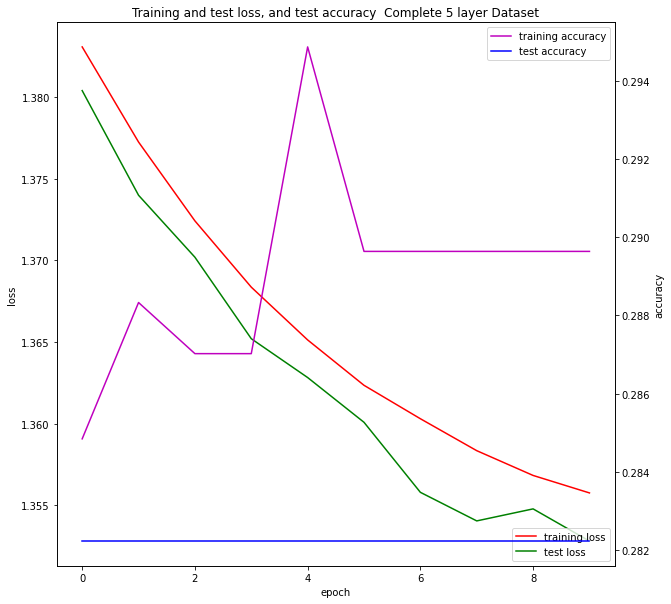

In [ ]:
fileName = 'cnnFT5Layers.pt'
fig, axs = plt.subplots(figsize=(10,10))
plot_loss_and_accuracy(fileName,axs, ' Complete 5 layer Dataset')
plt.show()

A model five offive CNN layers

In [ ]:

model5 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(256, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32768,32),    
    nn.ReLU(inplace=True),
    nn.Linear(32,len(classes))
)

for param in model5.parameters():
    print(param.shape)
_=model5(images)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([128, 256, 3, 3])
torch.Size([128])
torch.Size([32, 32768])
torch.Size([32])
torch.Size([4, 32])
torch.Size([4])


epoch: 0 training loss:  1.239 training accuracy:  46.3%  test loss:  1.260 test accuracy:  48.3%
epoch: 5 training loss:  0.528 training accuracy:  79.1%  test loss:  0.716 test accuracy:  71.4%
epoch: 10 training loss:  0.361 training accuracy:  85.6%  test loss:  0.554 test accuracy:  80.1%
epoch: 15 training loss:  0.184 training accuracy:  93.8%  test loss:  0.695 test accuracy:  73.7%
epoch: 20 training loss:  0.092 training accuracy:  97.4%  test loss:  0.430 test accuracy:  85.0%
epoch: 22 training loss:  0.092 training accuracy:  97.4%  test loss:  0.430 test accuracy:  85.0%


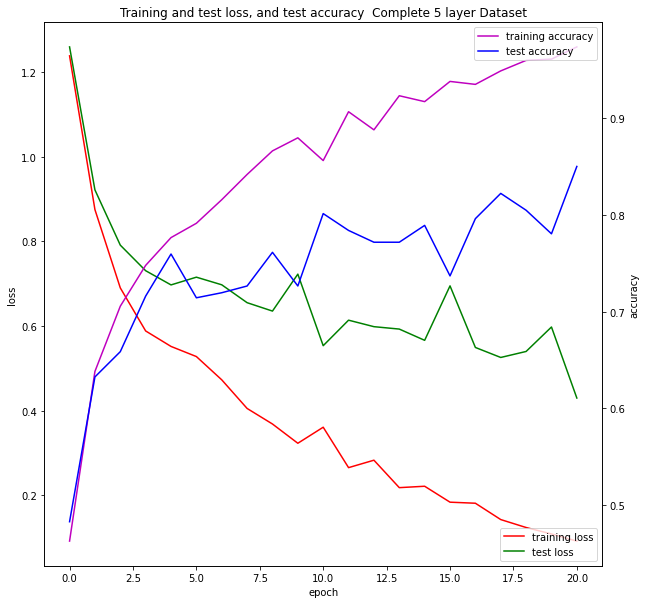

In [ ]:
fileName = 'cnnFTmodel5.pt'
train_model(model5, train_loader, test_loader, fileName, logging_epoch_criteria=5, lr=0.001)#, lr=0.0001
fig, axs = plt.subplots(figsize=(10,10))
plot_loss_and_accuracy(fileName,axs, ' Complete 5 layer Dataset')
plt.show()

# Evaluate the model

In [ ]:
final_test_set = ImageFolder(root='/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Testing', transform=transform )

In [ ]:
final_test_loader = torch.utils.data.DataLoader(
      final_test_set,
      batch_size=32,
      shuffle=True,
      num_workers=2
  )

Evaluationg the existing models with testing dataset

In [ ]:
def evaluate(model, loader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = model.eval()
  model.to(device)
  correct = 0
  total = 0

  cm = dict()
  total_cm = dict()
  for op_class in classes:
    cm[op_class] = 0
    cm[f"{op_class}_arr"] = []
    total_cm[op_class] = 0
    total_cm[f"{op_class}_arr"] = []
  for input, label in loader:
    input, labels = input.to(device), label.to(device)
    outputs = model(input)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)    # add in the number of labels in this minibatch
    for n in range(labels.size(0)):
      if(predicted[n]==labels[n]):
        cm[classes[labels[n]]]+=1
        cm[f"{classes[labels[n]]}_arr"].append(1)
        total_cm[f"{classes[labels[n]]}_arr"].append(1)
        for op_class in classes:
          if op_class != classes[labels[n]]:
            cm[f"{op_class}_arr"].append(0)
            total_cm[f"{op_class}_arr"].append(0)
      else:
        cm[f"{classes[labels[n]]}_arr"].append(0)
        cm[f"{classes[predicted[n]]}_arr"].append(1)
        total_cm[f"{classes[predicted[n]]}_arr"].append(0)
        total_cm[f"{classes[labels[n]]}_arr"].append(1)
      total_cm[classes[labels[n]]]+=1
    correct += (predicted == labels).sum().item()  # add in the number of correct labels
  print(f"total={total} correct ={correct}")
  for op_class in classes:
    print(f"total items for {op_class}={total_cm[op_class]} correct={cm[op_class]}")
  return (cm,total_cm)

performance measure of the models

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    print(f"TP={TP}, FP={FP}, TN={TN}, FN={FN}")
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = ( TP /(TP+FP) ) if (TP+FP) != 0 else 0
    FPR = "Not Defined"
    FNR = "Not Defined"
    #FDR = "Not Defined"
    # Fall out or false positive rate
    if((FP+TN)==0):
      FPR = FP/(FP+TN)
    # False negative rate
    if((TP+FN)==0):
      FNR = FN/(TP+FN)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print(f"TPR={TPR} TNR={TNR} PPV={PPV} FPR={FPR} FNR={FNR} ACC={ACC}")
    return(TP, FP, TN, FN)
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
def plot_cm(op):
  (predicted,actual) = op
  
  for op_class in classes:
    matrix = metrics.confusion_matrix(actual[f"{op_class}_arr"], predicted[f"{op_class}_arr"])
    perf_measure(actual[f"{op_class}_arr"], predicted[f"{op_class}_arr"])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
    print(op_class)
    cm_display.plot()
    plt.show()

    #print ROC curve
    RocCurveDisplay.from_predictions(
    actual[f"{op_class}_arr"],
    predicted[f"{op_class}_arr"],
    name=f"{op_class}",
    color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

model 1(net)
total=394 correct =278
total items for pituitary_tumor=100 correct=24
total items for glioma_tumor=115 correct=102
total items for meningioma_tumor=105 correct=100
total items for no_tumor=74 correct=52
TP=24, FP=11, TN=254, FN=76
TPR=0.24 TNR=0.9584905660377359 PPV=0.6857142857142857 FPR=Not Defined FNR=Not Defined ACC=0.7616438356164383
pituitary_tumor


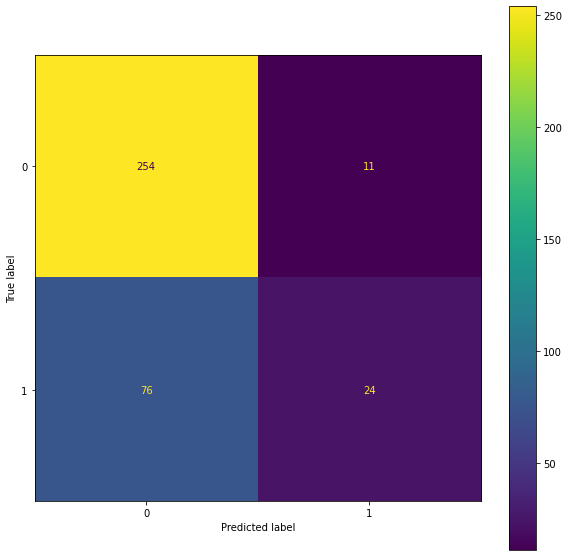

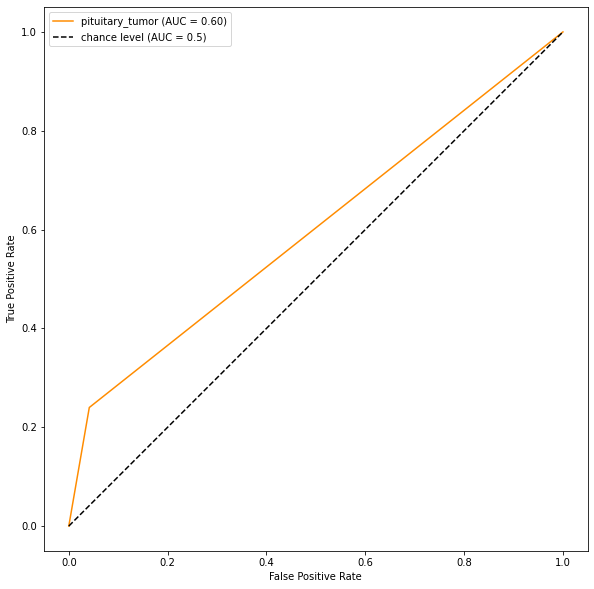

TP=102, FP=43, TN=176, FN=13
TPR=0.8869565217391304 TNR=0.8036529680365296 PPV=0.7034482758620689 FPR=Not Defined FNR=Not Defined ACC=0.8323353293413174
glioma_tumor


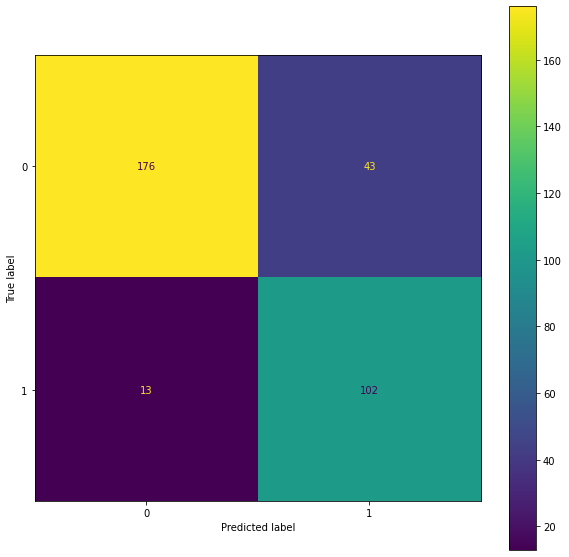

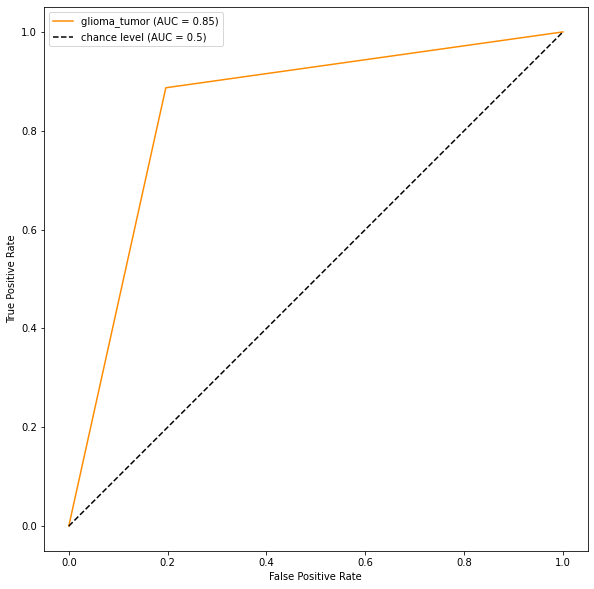

TP=100, FP=52, TN=178, FN=5
TPR=0.9523809523809523 TNR=0.7739130434782608 PPV=0.6578947368421053 FPR=Not Defined FNR=Not Defined ACC=0.8298507462686567
meningioma_tumor


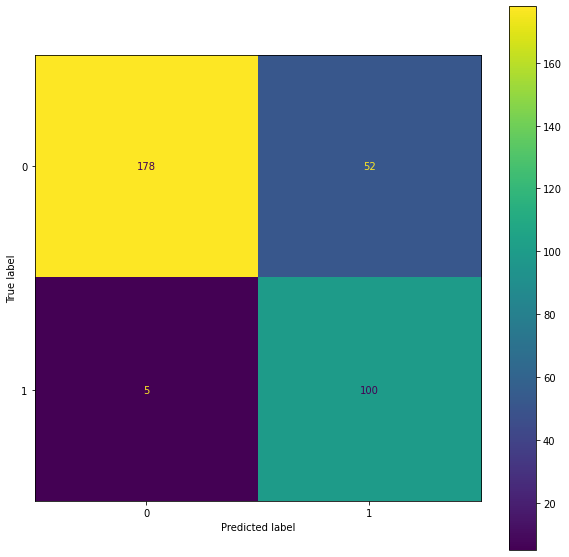

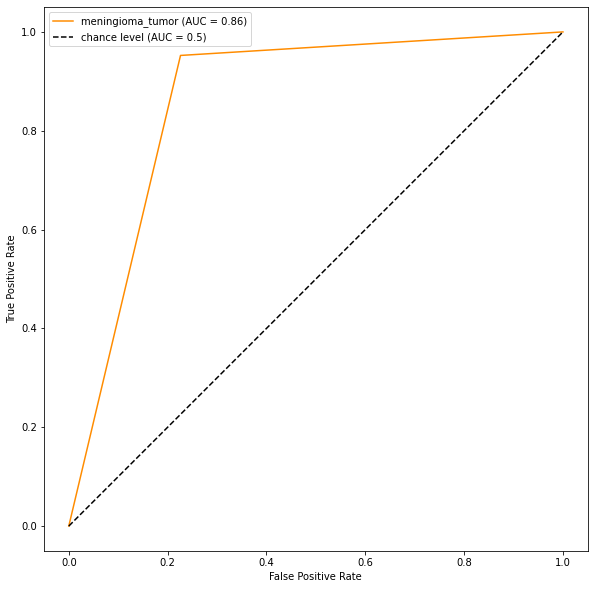

TP=52, FP=10, TN=226, FN=22
TPR=0.7027027027027027 TNR=0.9576271186440678 PPV=0.8387096774193549 FPR=Not Defined FNR=Not Defined ACC=0.896774193548387
no_tumor


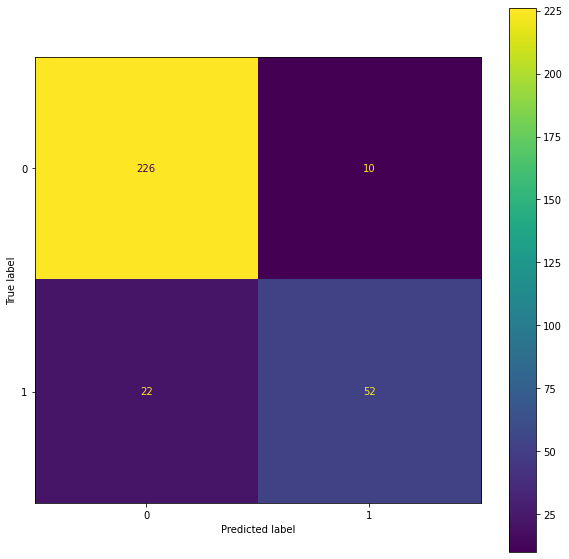

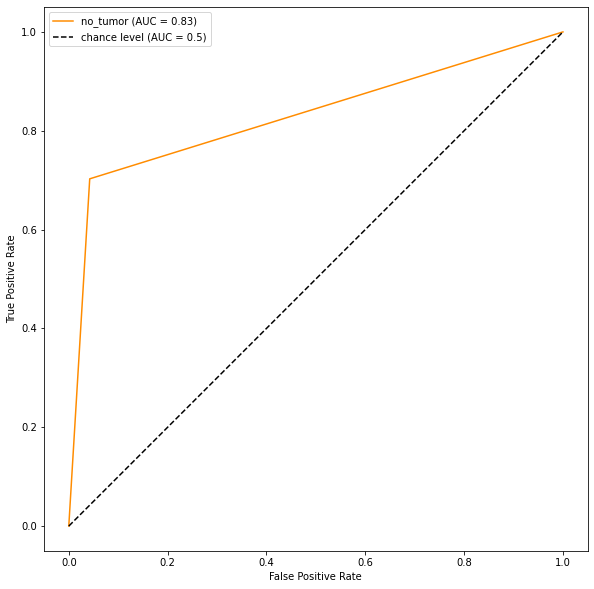

In [ ]:
print("model 1(net)")
plot_cm(evaluate(net, final_test_loader))

model 2
total=394 correct =261
total items for pituitary_tumor=100 correct=19
total items for glioma_tumor=115 correct=101
total items for meningioma_tumor=105 correct=102
total items for no_tumor=74 correct=39
TP=19, FP=5, TN=242, FN=81
TPR=0.19 TNR=0.979757085020243 PPV=0.7916666666666666 FPR=Not Defined FNR=Not Defined ACC=0.7521613832853026
pituitary_tumor


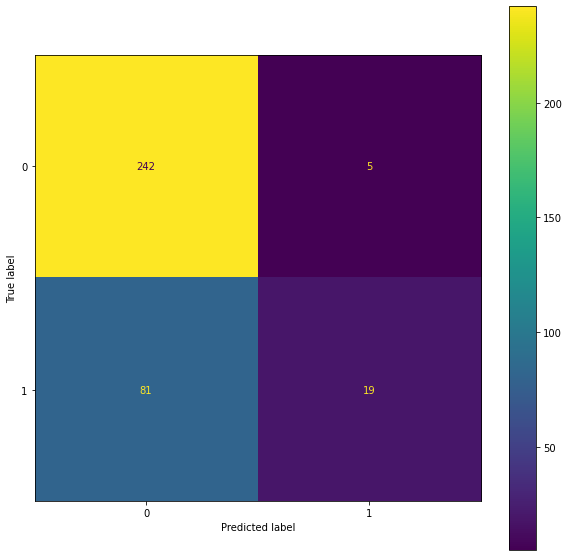

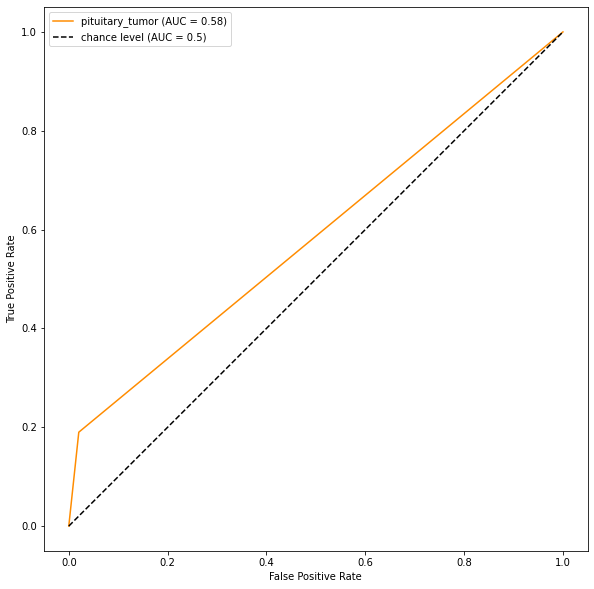

TP=101, FP=57, TN=160, FN=14
TPR=0.8782608695652174 TNR=0.7373271889400922 PPV=0.6392405063291139 FPR=Not Defined FNR=Not Defined ACC=0.786144578313253
glioma_tumor


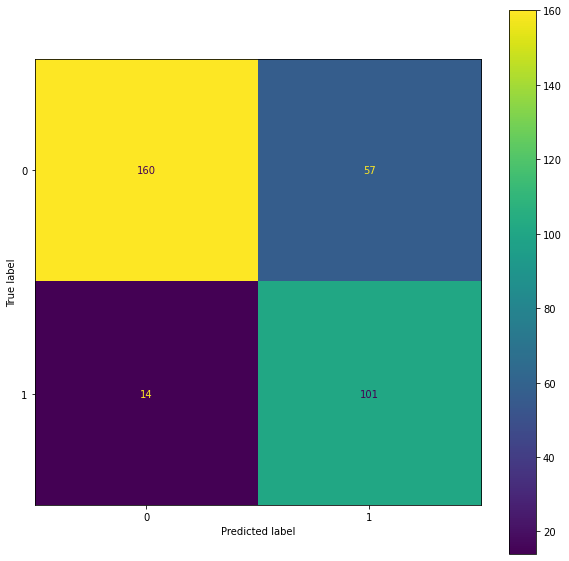

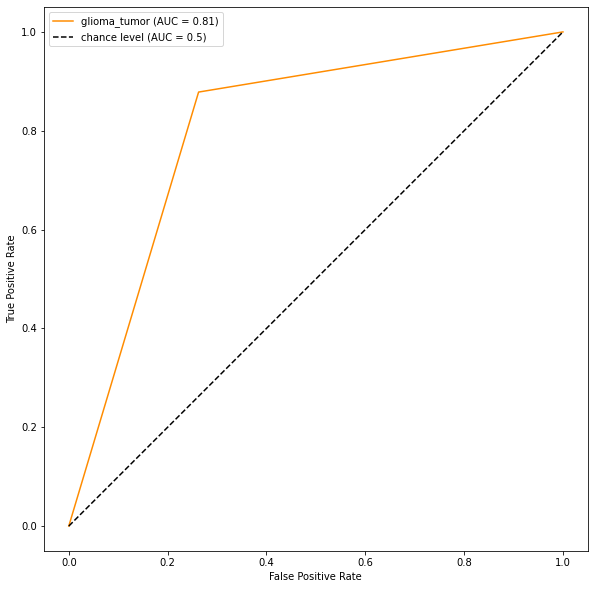

TP=102, FP=61, TN=159, FN=3
TPR=0.9714285714285714 TNR=0.7227272727272728 PPV=0.6257668711656442 FPR=Not Defined FNR=Not Defined ACC=0.803076923076923
meningioma_tumor


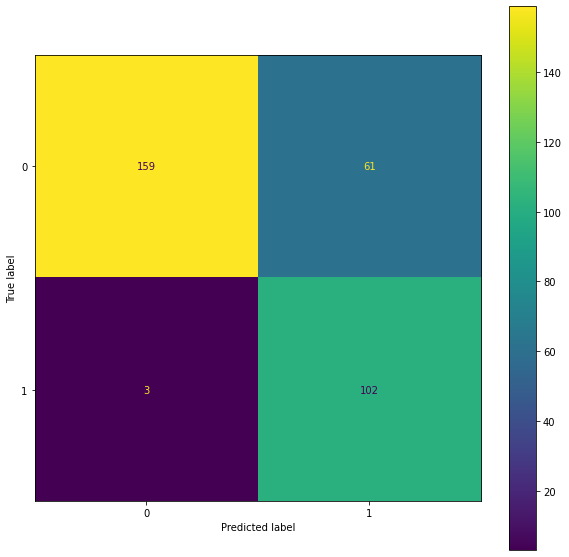

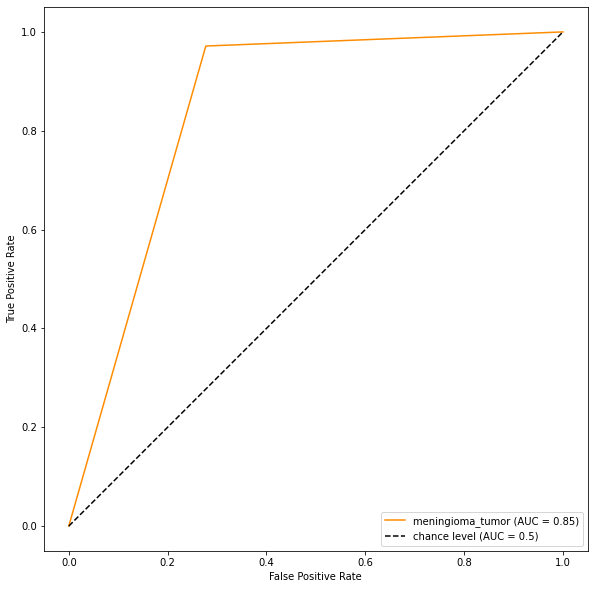

TP=39, FP=10, TN=222, FN=35
TPR=0.527027027027027 TNR=0.9568965517241379 PPV=0.7959183673469388 FPR=Not Defined FNR=Not Defined ACC=0.8529411764705882
no_tumor


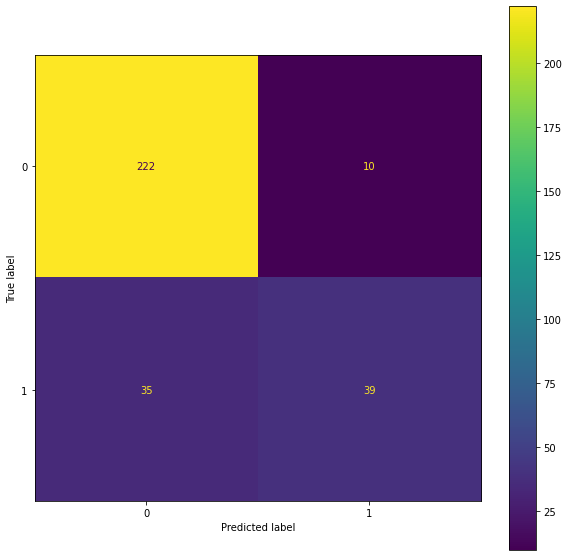

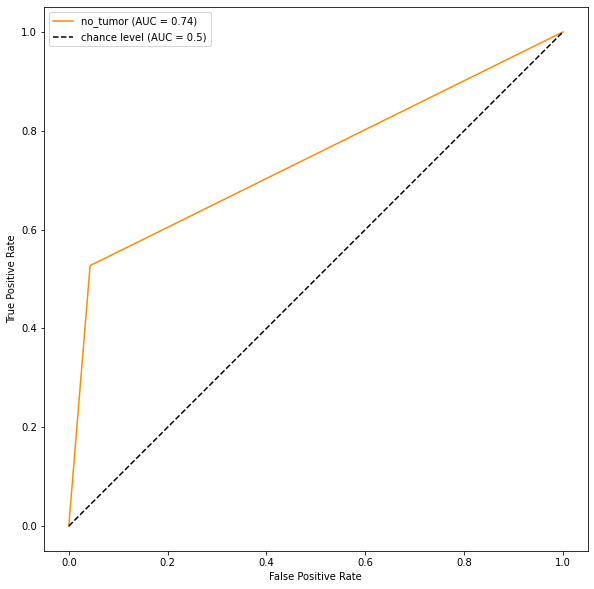

In [ ]:
print("model 2")
plot_cm(evaluate(model2, final_test_loader))

model 3
total=394 correct =232
total items for pituitary_tumor=100 correct=7
total items for glioma_tumor=115 correct=100
total items for meningioma_tumor=105 correct=88
total items for no_tumor=74 correct=37
TP=7, FP=5, TN=225, FN=93
TPR=0.07 TNR=0.9782608695652174 PPV=0.5833333333333334 FPR=Not Defined FNR=Not Defined ACC=0.703030303030303
pituitary_tumor


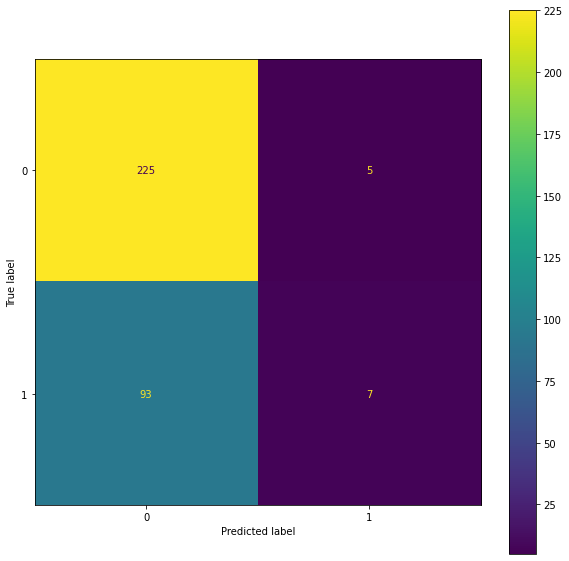

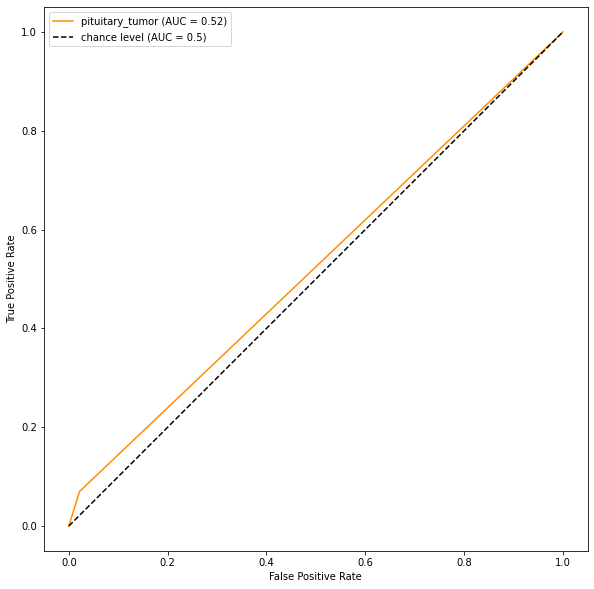

TP=100, FP=85, TN=132, FN=15
TPR=0.8695652173913043 TNR=0.6082949308755761 PPV=0.5405405405405406 FPR=Not Defined FNR=Not Defined ACC=0.6987951807228916
glioma_tumor


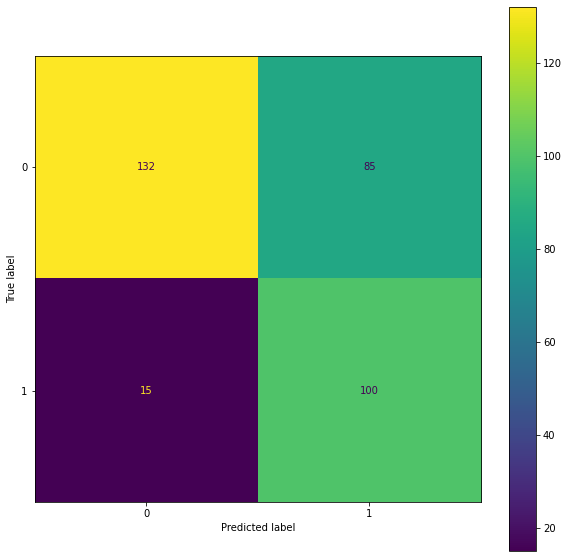

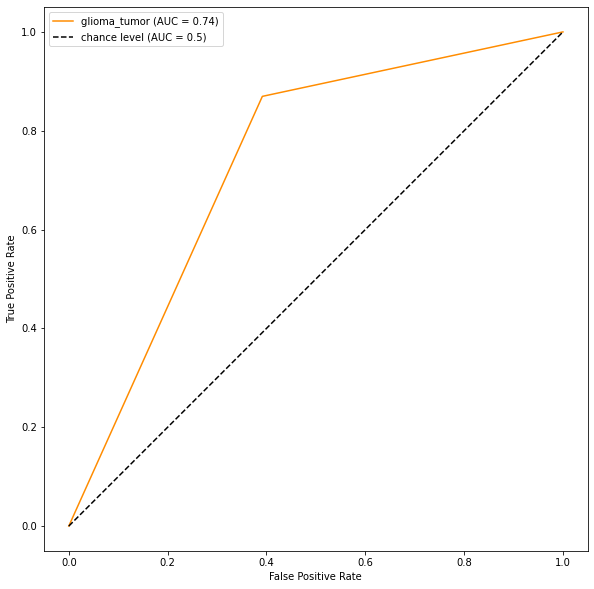

TP=88, FP=56, TN=144, FN=17
TPR=0.8380952380952381 TNR=0.72 PPV=0.6111111111111112 FPR=Not Defined FNR=Not Defined ACC=0.760655737704918
meningioma_tumor


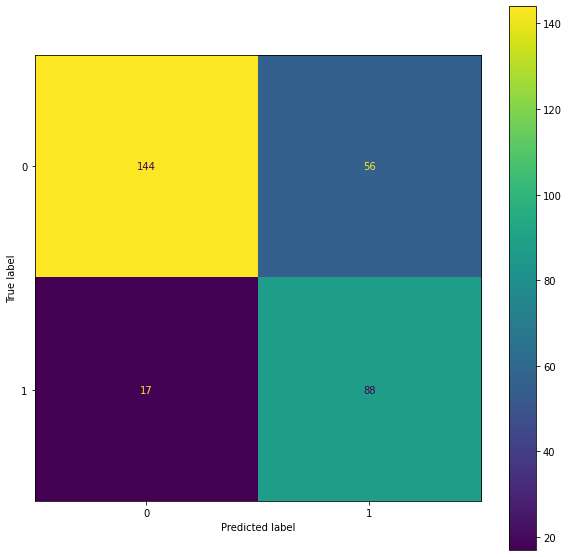

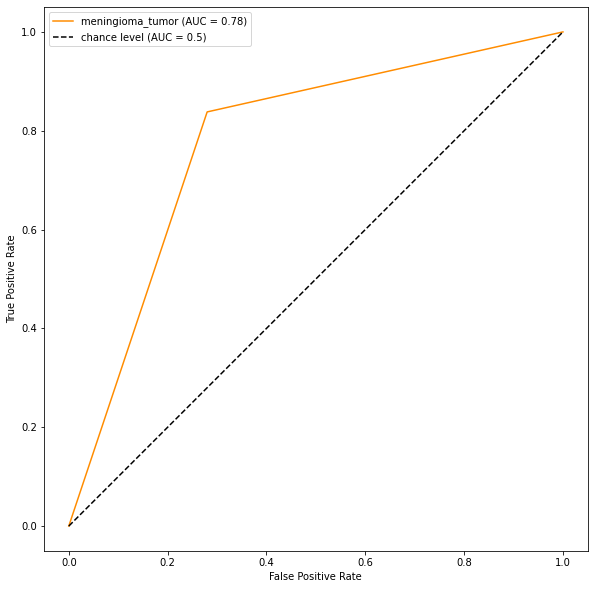

TP=37, FP=16, TN=195, FN=37
TPR=0.5 TNR=0.9241706161137441 PPV=0.6981132075471698 FPR=Not Defined FNR=Not Defined ACC=0.8140350877192982
no_tumor


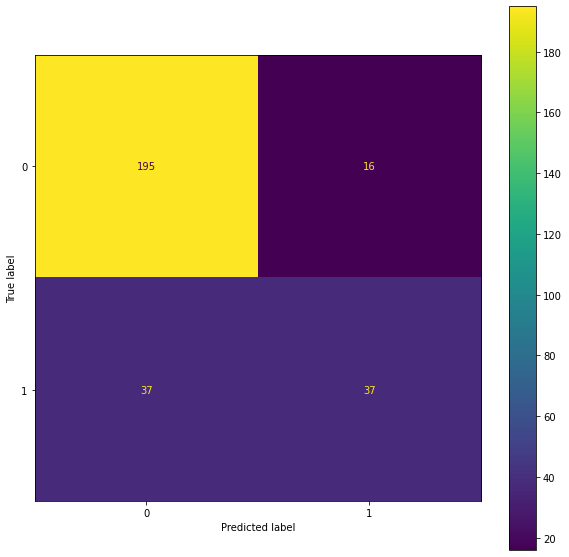

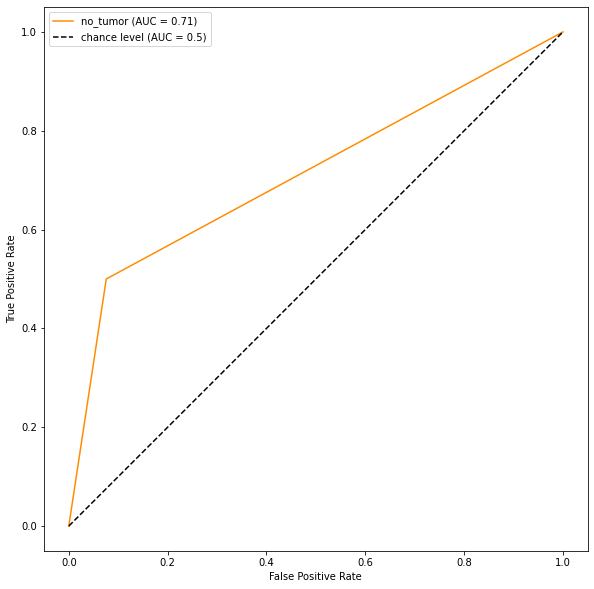

In [ ]:
print("model 3")
plot_cm(evaluate(model3, final_test_loader))

model 4
total=394 correct =74
total items for pituitary_tumor=100 correct=0
total items for glioma_tumor=115 correct=0
total items for meningioma_tumor=105 correct=0
total items for no_tumor=74 correct=74
TP=0, FP=0, TN=74, FN=100
TPR=0.0 TNR=1.0 PPV=0 FPR=Not Defined FNR=Not Defined ACC=0.42528735632183906
pituitary_tumor


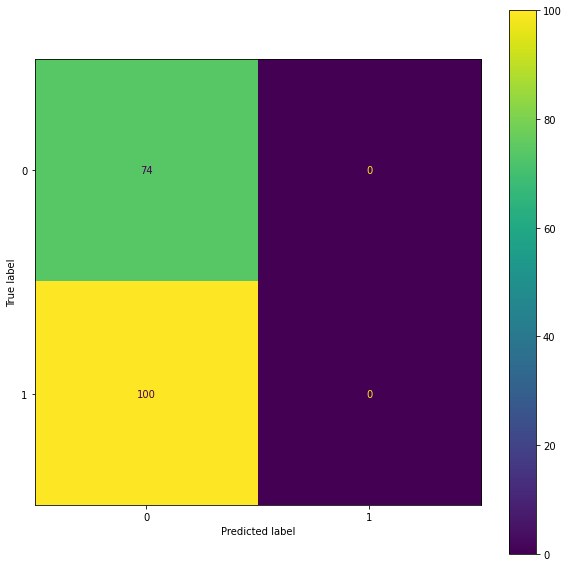

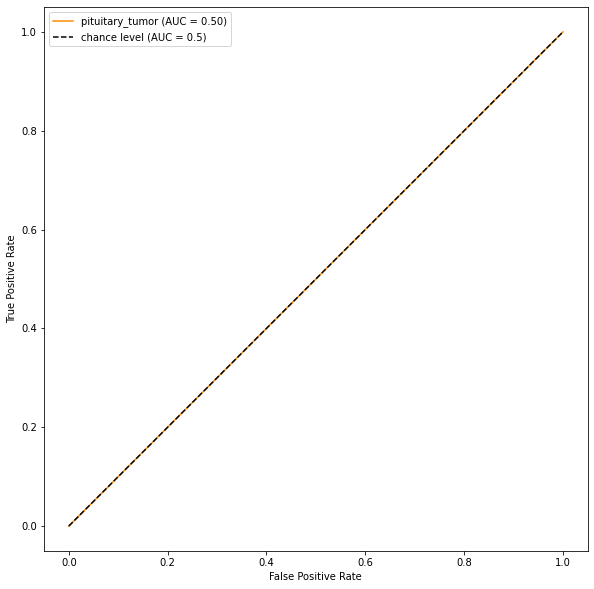

TP=0, FP=0, TN=74, FN=115
TPR=0.0 TNR=1.0 PPV=0 FPR=Not Defined FNR=Not Defined ACC=0.3915343915343915
glioma_tumor


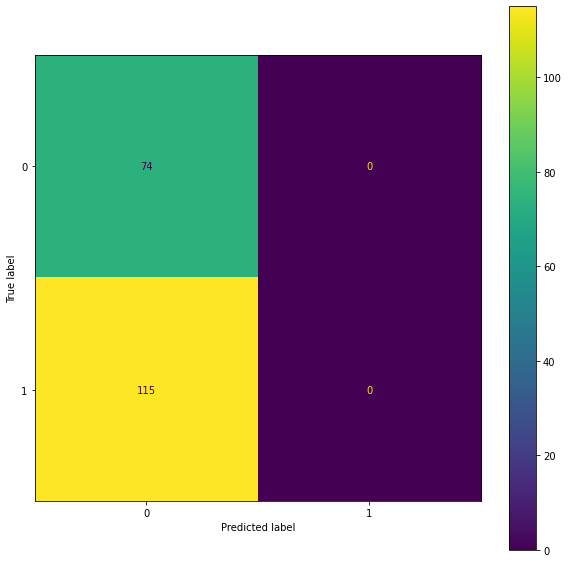

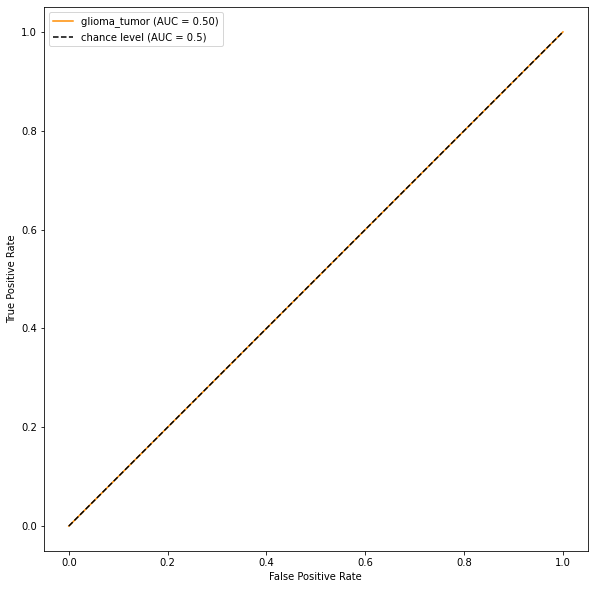

TP=0, FP=0, TN=74, FN=105
TPR=0.0 TNR=1.0 PPV=0 FPR=Not Defined FNR=Not Defined ACC=0.4134078212290503
meningioma_tumor


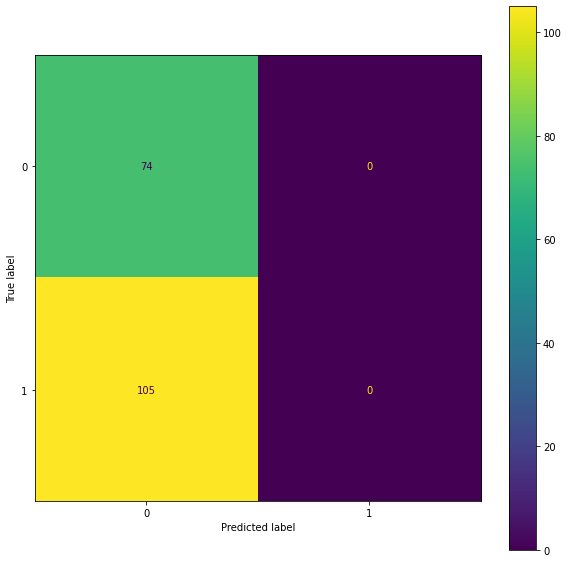

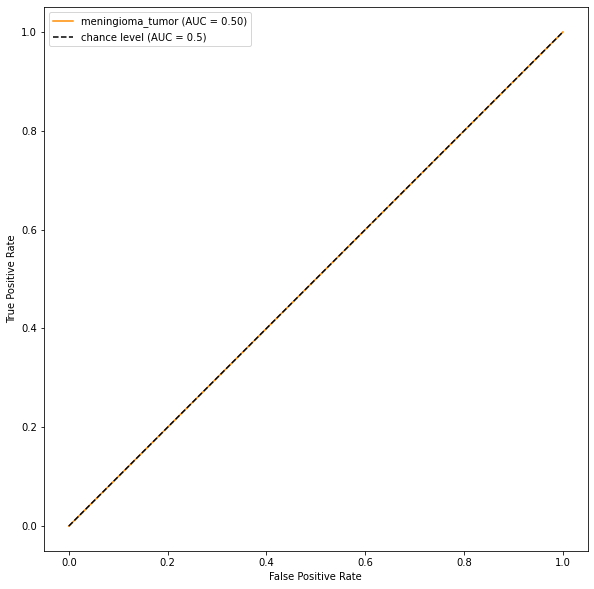

TP=74, FP=320, TN=0, FN=0
TPR=1.0 TNR=0.0 PPV=0.18781725888324874 FPR=Not Defined FNR=Not Defined ACC=0.18781725888324874
no_tumor


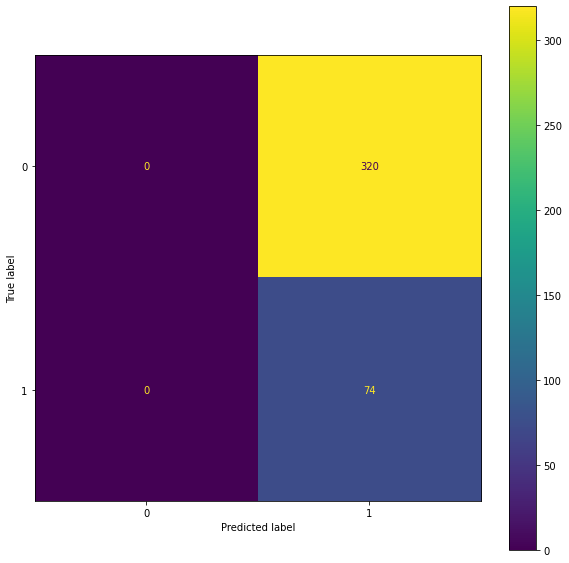

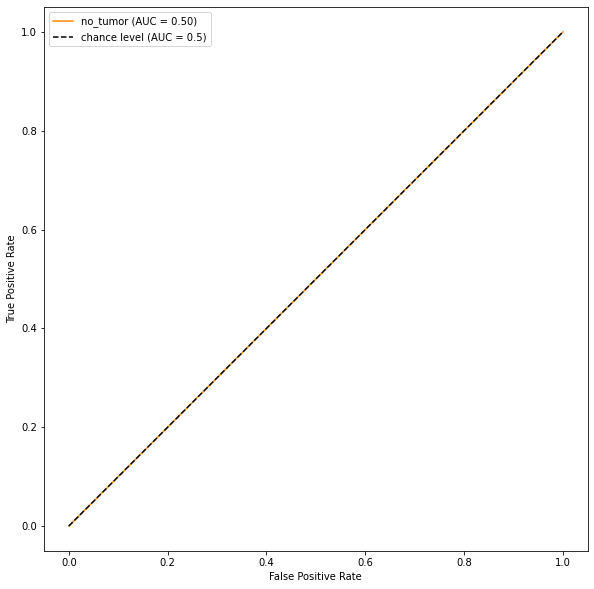

In [ ]:
print("model 4")
plot_cm(evaluate(model4, final_test_loader))

model 5
total=394 correct =245
total items for pituitary_tumor=100 correct=6
total items for glioma_tumor=115 correct=104
total items for meningioma_tumor=105 correct=94
total items for no_tumor=74 correct=41
TP=6, FP=2, TN=239, FN=94
TPR=0.06 TNR=0.991701244813278 PPV=0.75 FPR=Not Defined FNR=Not Defined ACC=0.718475073313783
pituitary_tumor


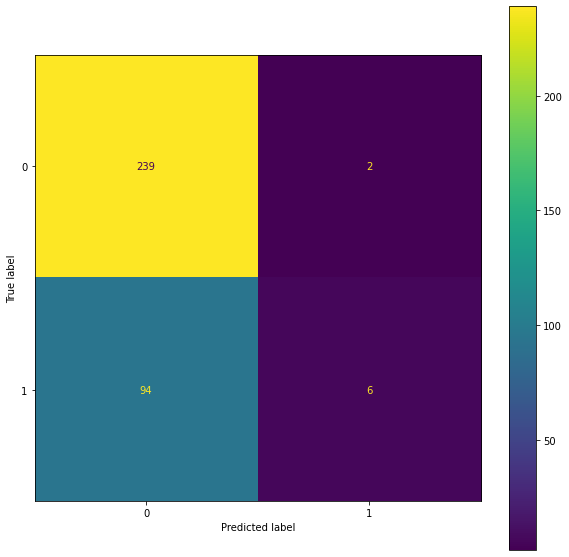

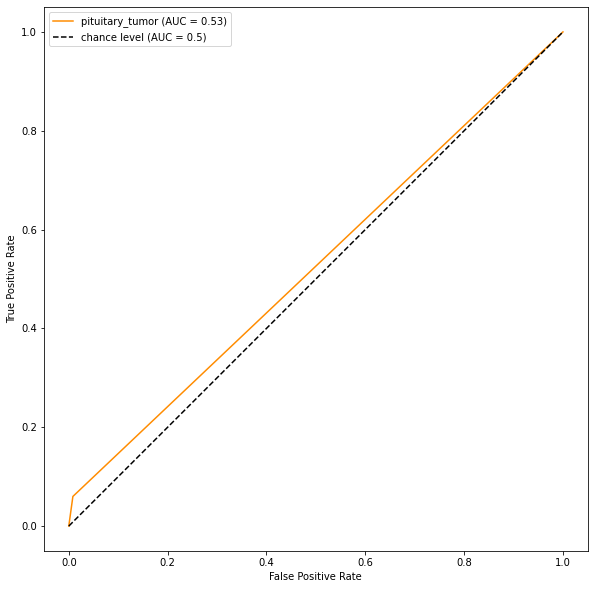

TP=104, FP=88, TN=141, FN=11
TPR=0.9043478260869565 TNR=0.6157205240174672 PPV=0.5416666666666666 FPR=Not Defined FNR=Not Defined ACC=0.7122093023255814
glioma_tumor


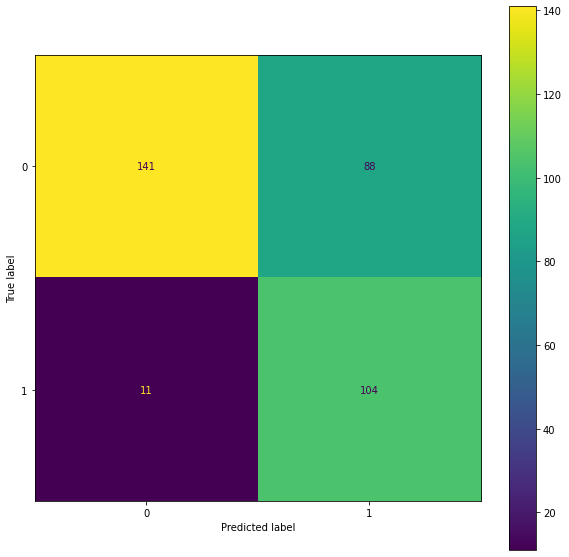

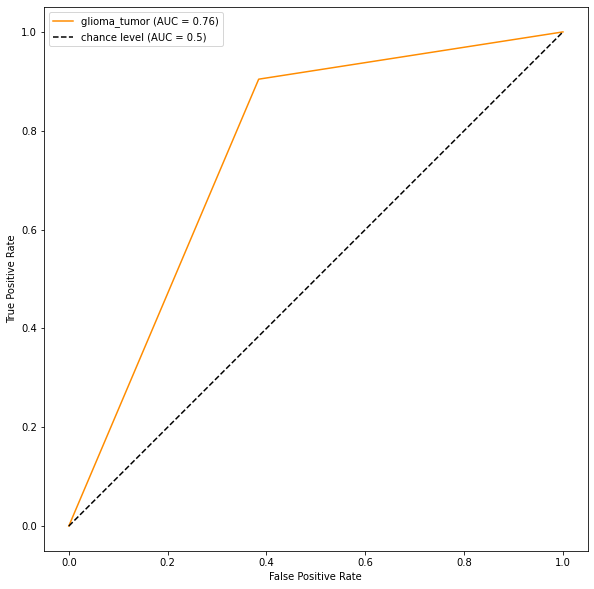

TP=94, FP=46, TN=151, FN=11
TPR=0.8952380952380953 TNR=0.766497461928934 PPV=0.6714285714285714 FPR=Not Defined FNR=Not Defined ACC=0.8112582781456954
meningioma_tumor


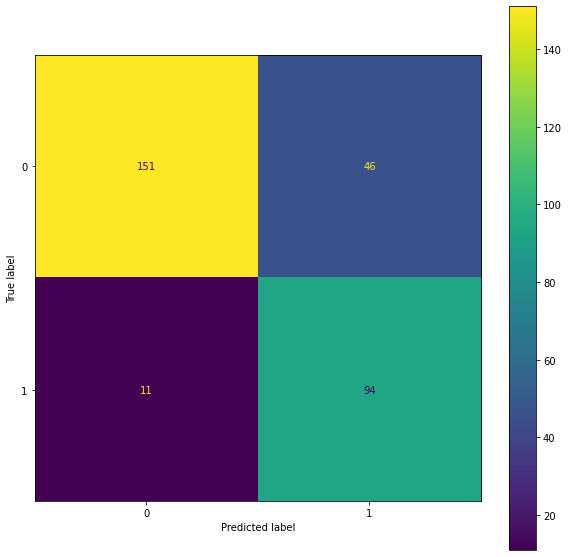

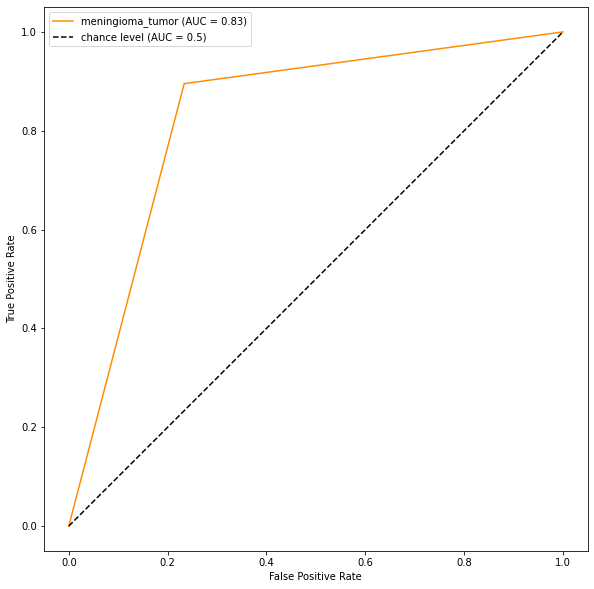

TP=41, FP=13, TN=204, FN=33
TPR=0.5540540540540541 TNR=0.9400921658986175 PPV=0.7592592592592593 FPR=Not Defined FNR=Not Defined ACC=0.8419243986254296
no_tumor


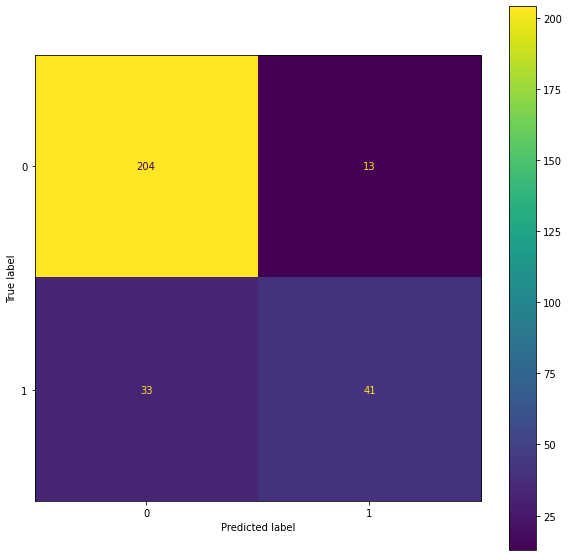

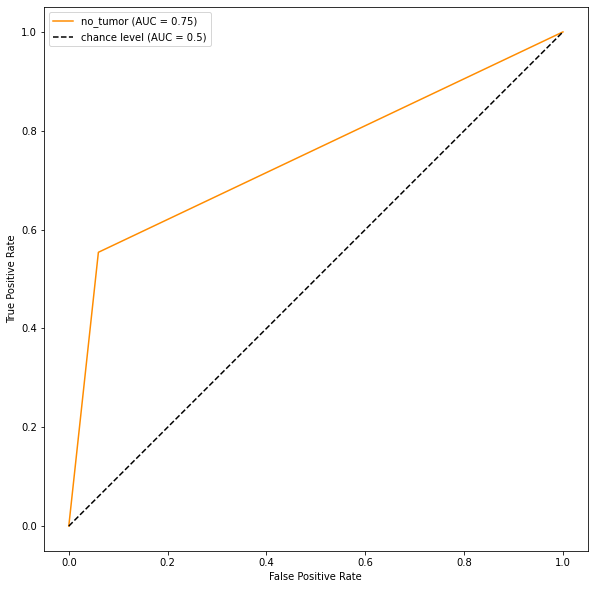

In [ ]:
print("model 5")
plot_cm(evaluate(model5, final_test_loader))